# PIC 16A Group Project  
## Group 23
*   Haoran Jia
*   Kunning Wang
*   Vincent Chiu  

## Group Contribution Statement
*`Haoran` wrote the data acquisition and preparation. `Haoran` led the Scatterplot Figure and the Random Forest model. `Vincent` led the boxplot figure and the Neural Network model. `Kunning` led the Table, Histogram figure, and the Logistic regression model. Each person wrote the explanation for the sections they coded, and `Vincent` wrote the conclusion. We all checked each otherâ€™s work and made revisions to code and writing. Modfications were made so functions are wrapped and code is not needlessly repeated.*



## Data Acquisition


There maybe some warnings due to package version or keywords update, so we can ignore these warnings with the following code


In [ ]:
import warnings
warnings.filterwarnings('ignore')

We will be using cross validation score as evaluating metric, so we are importing `cross_val_score` along with many other necessary modules at the very beginning.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score

# download data
url = 'https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv'
penguins = pd.read_csv(url)

We can take a quick glance at the data

In [ ]:
penguins.head()

studyName  Sample Number  ... Delta 13 C (o/oo)                        Comments
0   PAL0708              1  ...               NaN  Not enough blood for isotopes.
1   PAL0708              2  ...         -24.69454                             NaN
2   PAL0708              3  ...         -25.33302                             NaN
3   PAL0708              4  ...               NaN              Adult not sampled.
4   PAL0708              5  ...         -25.32426                             NaN

[5 rows x 17 columns]

## Exploratory Analysis


### Data Preperation

First, we want to split the whole dataset into training and testing sets. We intentionally do this before any further operation on raw data to avoid polluting the testing set with any training set information, and 20% of the data will be reserved for the testing set.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(penguins, test_size = 0.2, random_state = 100)

Since we want to use our data to determine the species of penguins, we split our dataframe into `X`, the feature variables, and `y`, the target variable. Every y will containthe label column ***species***:

    Species: a character string denoting the penguin species
    

In [ ]:
# split the dataframe into features and labels 
X_train = train.drop(['Species'], axis = 1)
y_train = train['Species']
X_test = test.drop(['Species'], axis = 1)
y_test = test['Species']

In [ ]:
print(f"The shape of the whole dataset is {penguins.shape}")
print(f"The shape of the training set is  {X_train.shape}")
print(f"The shape of the testing set is   {X_test.shape}")

The shape of the whole dataset is (344, 17)
The shape of the training set is  (275, 16)
The shape of the testing set is   (69, 16)


By using class function `info()`, we are able to see all the columns, non-null term counts, and data type, which are crucial for us to gain an overall understanding of our dataset. We can create a simple wrapper function `info_disp()` to display information for training and testing features at the same time. As shown below, we have 16 features, in which 7 are quantitive, and others are qualititive. 

In [ ]:
def info_disp(X_train, X_test):
    '''
    This is a function simply return the result of info() for train and test set
    '''
    print(X_train.info())
    print("-"*50)
    print(X_test.info())
    print("-"*50)
    
info_disp(X_train, X_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275 entries, 331 to 8
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            275 non-null    object 
 1   Sample Number        275 non-null    int64  
 2   Region               275 non-null    object 
 3   Island               275 non-null    object 
 4   Stage                275 non-null    object 
 5   Individual ID        275 non-null    object 
 6   Clutch Completion    275 non-null    object 
 7   Date Egg             275 non-null    object 
 8   Culmen Length (mm)   274 non-null    float64
 9   Culmen Depth (mm)    274 non-null    float64
 10  Flipper Length (mm)  274 non-null    float64
 11  Body Mass (g)        274 non-null    float64
 12  Sex                  267 non-null    object 
 13  Delta 15 N (o/oo)    264 non-null    float64
 14  Delta 13 C (o/oo)    265 non-null    float64
 15  Comments             19 non-null     obj

We want to first explore the NA values in our datasets because if a feature contains a significant number of NA values, it is most likely that this feature will not provide any meaningful information for our machine learning model to learn. As shown below, feature ***comments*** is a descriptive feature that has lots of NA values, so we will just choose to get rid of it later during data cleaning.

In [ ]:
# We counts the number of NA values in each column of training set, if there exists any  
X_train.isnull().sum()[X_train.isnull().sum()>0]

Culmen Length (mm)       1
Culmen Depth (mm)        1
Flipper Length (mm)      1
Body Mass (g)            1
Sex                      8
Delta 15 N (o/oo)       11
Delta 13 C (o/oo)       10
Comments               256
dtype: int64

Moreover, we may want to drop the columns with variance 0. Because if all the data has the same value within the column, it cannot provide useful information for us to accomplish a multi-class classification task. Thus we drop features ***studyName, Region***, and ***Stage***.\
By reading feature description found online, we konw that ***Sample Number***, and ***Individual ID*** should be variables randomly assigned to each penguin with little statistical significance, so they will be dropped as well. 


    studyName: Sampling expedition from which data were collected, generated, etc.
    Stage: a character string denoting reproductive stage at sampling
    Region: a character string denoting the region of Palmer LTER sampling grid
    Sample Number: an integer denoting the continuous numbering sequence for each sample
    Individual ID: a character string denoting the unique ID for each individual in dataset


By reading the remaining data description, we assume ***Date Egg*** will be less important than other features, therefore we drop it as well. 

    Island: a character string denoting the island near Palmer Station where samples were collected
    Clutch Completion: a character string denoting if the study nest observed with a full clutch, i.e., 2 eggs
    Culmen Length: a number denoting the length of the dorsal ridge of a bird's bill (millimeters)
    Culmen Depth: a number denoting the depth of the dorsal ridge of a bird's bill (millimeters)
    Flipper Length: an integer denoting the length penguin flipper (millimeters)
    Body Mass: an integer denoting the penguin body mass (grams)
    Sex: a character string denoting the sex of an animal
    Delta 15 N: a number denoting the measure of the ratio of stable isotopes 15N:14N
    Delta 13 C: a number denoting the measure of the ratio of stable isotopes 13C:12C
    Date Egg: a date denoting the date study nest observed with 1 egg (sampled)

We collect columns to be dropped into `drop_cols`

In [ ]:
drop_cols = ["Comments", "Date Egg", "Sample Number", 
             "Individual ID", "studyName", "Region", "Stage"]

We noticed that there is an unusual value `.` for sex during data exploration, so we need to delete it during cleaning.

In [ ]:
penguins['Sex'].unique()

array(['MALE', 'FEMALE', nan, '.'], dtype=object)

The data preprocessing process for both testing and training are similar, so it is more reasonable for us to write a wrapper function `data_preperation` that contains desired operations to avoid code repetition.\
Since machine learning models recognize numeric variables instead of strings, we first import module `preprocessing` from `sklearn`, and use its function `LabelEncoder()` to apply numeric representation for catagorical data.

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
    
def data_preperation(df, label, drop_cols):
    '''
    This is a wrapper function containing all the data preprocessing work
    
    Parameters:
    df, dataframe to be cleaned
    label, label column from penguins
    drop_cols, columns hoping to drop 
    
    Return:
    df / label, processed df and label 
    mappings, record of how catagorical variables correspond to numeric values
    '''
    df = df[df["Sex"] != "."] # exclude the data where sex = "." 
    
    # drop useless columns
    df.drop(columns = drop_cols, axis = 1, inplace = True) 
    df = df.dropna() # drop the rows containing NA 
    index = df.index # takes the index to extract the corresponding labels
    
    
    # transform the labels into numeric values
    label = label.str.split().str.get(0)
    label = label.loc[index]
    label = le.fit_transform(label)
    
    mappings = {} # create an empty dictionary to store mapping information
    mappings["label"] =  dict(zip(le.classes_,range(len(le.classes_))))
    
    # transform the catagorical features into numeric forms, and save its mapping in the mappings dictionary
    df['Sex']    = le.fit_transform(df['Sex'])
    mappings["Sex"] = dict(zip(le.classes_,range(len(le.classes_))))
    
    df['Island'] = le.fit_transform(df['Island'])
    mappings["Island"] = dict(zip(le.classes_,range(len(le.classes_))))
    
    df['Clutch Completion'] = le.fit_transform(df['Clutch Completion'])
    mappings['Clutch Completion'] = dict(zip(le.classes_,range(len(le.classes_))))

    return df, label, mappings


In [ ]:
# apply the function to training and testing sets
X_train, y_train, mappings= data_preperation(X_train, y_train, drop_cols)
X_test , y_test, mappings = data_preperation(X_test, y_test, drop_cols)

In [ ]:
# display mapping information
for key, value in mappings.items():
    print(key,": ", value)

label :  {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}
Sex :  {'FEMALE': 0, 'MALE': 1}
Island :  {'Biscoe': 0, 'Dream': 1, 'Torgersen': 2}
Clutch Completion :  {'No': 0, 'Yes': 1}


After conducting data preprecessing, we may want to check if the datasets are really clean. We can call `info_disp` again and as shown below, all the data have same number of `non-null` count, and data type of either `int64` or `float64`. The data is indeed in a good shape.

In [ ]:
info_disp(X_train, X_test)
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of y_test is  {y_test.shape}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 331 to 280
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Island               258 non-null    int64  
 1   Clutch Completion    258 non-null    int64  
 2   Culmen Length (mm)   258 non-null    float64
 3   Culmen Depth (mm)    258 non-null    float64
 4   Flipper Length (mm)  258 non-null    float64
 5   Body Mass (g)        258 non-null    float64
 6   Sex                  258 non-null    int64  
 7   Delta 15 N (o/oo)    258 non-null    float64
 8   Delta 13 C (o/oo)    258 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 20.2 KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 308 to 169
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Island               66 non

The next step is exploratory data analysis(EDA) with our cleaned data. We assume that we may want to use ***species***(the labels) as a grouping variable so in order to perform EDA with ease, we create a copy of `X_train` containing column ***species***

In [ ]:
df = X_train.copy(deep = True)
df['Species'] = y_train

In [ ]:
df.columns

Index(['Island', 'Clutch Completion', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Species'],
      dtype='object')

### Table and graphs

First, in order to gain some insights purely from a statistical respect, we create a function called `penguin_summary_table` to summarize `mean` and `median` for numeric columns, grouped by species.  

In [ ]:
def penguin_summary_table(df, group_cols, value_cols):
    '''
    Parameters:
    df, dataframe to work on
    group_cols, columns hoping to be summarized 
    value_cols, grouping column
    
    Return:
    A summary table 
    '''
    return df.groupby(group_cols)[value_cols].aggregate([np.mean, np.median]) 

By the mappings, we can specify ***Species*** as `{'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}`, Island as `{'Biscoe': 0, 'Dream': 1, 'Torgersen': 2}` and Sex as `{'FEMALE': 0, 'MALE': 1}`

In [ ]:
value_cols = ["Culmen Length (mm)","Culmen Depth (mm)","Flipper Length (mm)","Body Mass (g)",
              'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
penguin_summary_table(df, ["Species","Island","Sex"], value_cols)

Culmen Length (mm)         ... Delta 13 C (o/oo)           
                                 mean median  ...              mean     median
Species Island Sex                            ...                             
0       0      0            37.037500  37.65  ...        -25.840379 -26.008720
               1            40.875000  41.05  ...        -25.971155 -26.040685
        1      0            36.937500  36.75  ...        -25.702414 -25.811245
               1            40.070000  40.25  ...        -25.810602 -26.013505
        2      0            37.792857  38.55  ...        -25.872798 -25.925700
               1            40.756250  41.45  ...        -25.892778 -26.062195
1       1      0            46.138462  46.40  ...        -24.573087 -24.575555
               1            51.196429  50.95  ...        -24.572420 -24.595310
2       0      0            45.679167  45.50  ...        -26.218438 -26.222495
               1            49.793478  49.80  ...        -26.178261 -26.274430

[10 rows x 12 columns]

Information from the table shows that although there is no single column that separates three species at the same time, ***culmen Length (mm)***, ***Culmen Depth (mm)***, ***Flipper Length (mm)***, ***Body Mass (g)*** show similarities in two groups against the other. So they may be informative colunmns to separate one species from the three. And as the values are close for ***Delta 15 N (o/oo)*** and ***Delta 13 C (o/oo)***, a closer look at their distribution may be helpful.

Generating boxplots will better help us visualize the general behaviour of these quantitative features in each penguin species. As seen below, we can easily observe the quartile and outliers of each quantitative feature. By selecting features where the differences between species is stark for modeling, we will likely obtain a more accurate result. 


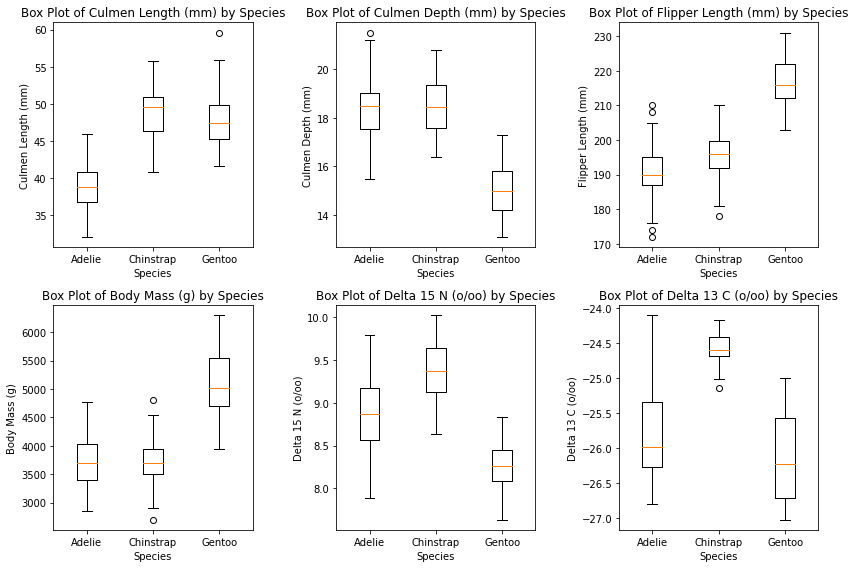

In [ ]:
#make figure with 2x3 boxplots
fig, ax = plt.subplots(2, 3, figsize = (12,8))

#iterate through all quantitative feature
for i in range(len(value_cols)):
    col = value_cols[i]
    data = []
    #retrieve info for the quantitative feature
    for j in range(len(df['Species'].unique())):
        data.append(df[df['Species'] == j][col])
    #plot box plot and add label
    box = ax[int(i/3)][int(i%3)].boxplot(data)
    ax[int(i/3)][int(i%3)].set(xlabel = 'Species',
                    ylabel = col,
                    title = 'Box Plot of ' + col + ' by Species')
#add ticks for species and make figure pretty
plt.setp(ax, xticks=[1,2,3], xticklabels = ['Adelie', 'Chinstrap', 'Gentoo'])
plt.tight_layout()

Looking at the boxplot, 
- Delta 15N and Delta 13C seem to be the most different among each species, but they also have a high variability. 
- Culmen length, culmen depth, and body mass all display result where two penguins appear similar while the other one is very different. 

Therefore by combining two of such features, we will be able to predict the species of the penguin fairly accurately. 

Next we decide to create histograms for each feature in order to explore their distribution

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


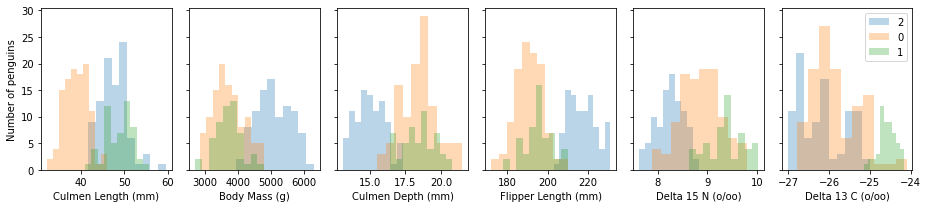

In [ ]:
from matplotlib import rcParams
config = {
    "font.family":"times new roman",    #serif
    "font.size": 10,
    "mathtext.fontset":'stix',
}
rcParams.update(config)
#set the graphs
fig, ax = plt.subplots(1,6, figsize = (13,3), sharey = True)
ax[0].set(ylabel = "Number of penguins")
#pick features we want to graph
features = ["Culmen Length (mm)", "Body Mass (g)", 
            "Culmen Depth (mm)","Flipper Length (mm)",
           "Delta 15 N (o/oo)","Delta 13 C (o/oo)"]
#use for loop to read in corresponding variables
for i in range(0,len(features)):
    for s in df["Species"].unique():
        df1 = df[df["Species"] == s]
        ax[i].hist(df1[features[i]], label = s, alpha = 0.3)
        ax[i].set(xlabel = features[i])
#print the histogram    
plt.tight_layout()
plt.legend()

- From the histogram of ***Culmen Length***, we can see that Adelie penguins have significantly shorter culmen than the other two species. Most of the blue bars fall behind of the green ones(Gentoo) and orange ones(Chinstrap).
- From the histogram of ***Body Mass***, we can see that Gentoo penguins are significantly heavier than the other two species. Most of the green bars fall ahead of the blue ones(Adelie) and orange ones(Chinstrap).
- From the histogram of ***Flipper length***, we can see that Gentoo penguins have significantly longer flippers than the other two species. Most of the green bars fall ahead of the blue ones(Adelie) and orange ones(Chinstrap).
- From the histogram of ***Culmen Depth***, we can see that Gentoo penguins have significantly more shallow culmens than the other two species. Most of the green bars fall behind of the blue ones(Adelie) and orange ones(Chinstrap).
- We can't get a clear sense simply from one elements of the isotopic ratios in feature(15N, 13C), so it may indicate that these two features are less informative.
- Based on characteristic of each graph, we'd like to say ***Culmen length*** might be a good variable to use, since it shows the unique feature of Adelie penguins. Gentoo penguins are different from the others in Body mass, culmen depth and flipper length. Hence we'll only pick one of the three variables to exam as the second quantitive variable. 

We continue to explore ***Culmen Length (mm)***, ***Culmen Depth (mm)***, ***Flipper Length (mm)***, ***Body Mass (g)***, features that are seemingly more helpful. We designed a function `pair_scatter` to create scatter plot for any two of those four features, and again, group by ***species***. In some sense, it is reasonable to separate these four from ***Delta 15 N (o/oo)*** and ***Delta 13 C (o/oo)***, because the former are apparent characteristics of penguins, while the latter two are more like implicit biological features. 

In [ ]:
def pair_scatter(df, cols, figsize):
    '''
    Takes cols and figsize as parameters, and create graphs for any two features in cols.
    '''
    fig, ax = plt.subplots(len(cols), len(cols), figsize = figsize)
    # create a dictionary to help create subplots
    Dcols = {cols[index]: index for index in range(len(cols))}
    
    for i in cols:
        for j in cols:
            if i != j: # create graph except the diagonal 
                sns.scatterplot(x = i, y = j, hue = 'Species', data = df, ax = ax[Dcols[i], Dcols[j]])
                
    plt.tight_layout()
    

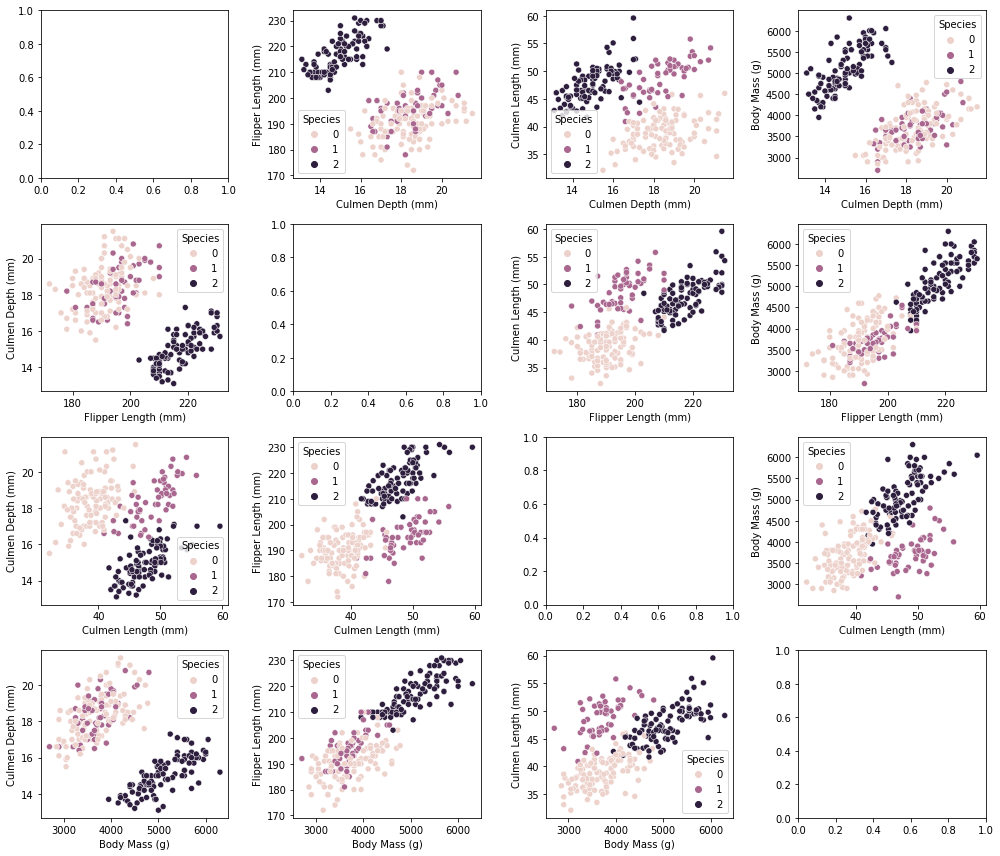

In [ ]:
cols = ['Culmen Depth (mm)', 'Flipper Length (mm)', 'Culmen Length (mm)', 'Body Mass (g)']
pair_scatter(df, cols, figsize = (14,12))

Most noticeably, the pair graphs show that ***Flipper Length (mm)*** vs ***Culmen Depth (mm)***, and ***Body Mass (g)*** vs ***Culmen Depth (mm)*** did a good job in spliting species 2 (Gentoo) from species 1(Chinstrap) and 0(Adelie). ***Culmen Length (mm)*** against ***Flipper Length (mm)*** shows clearly three groups with a few overlapped data points. 

## Modeling


In [ ]:
#Saving a copy of clean data so other models can retrieve clean data
save_X_train = X_train
save_y_train = y_train
save_X_test = X_test
save_y_test = y_test

### Model 1: RandomForestClassifier

#### Feature Selection

After performing EDA to our dataset, we can start with feature selection in this section. We are going to filter features in two steps, filter out obviously irrelavant features first, and then use an exhaustive search approach, evaluated by cross validation score, to decide on the remaining features. 

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


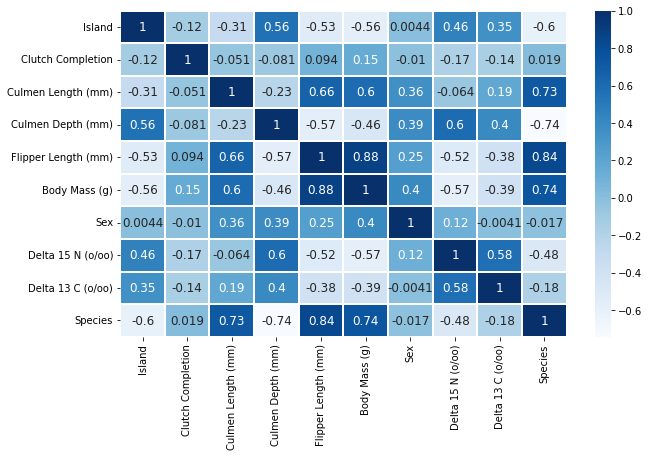

In [ ]:
# The heat map shows the overal correlation between different features and label 
fig, ax = plt.subplots(figsize = (10,6))
sns.heatmap(df.corr(),annot=True, cmap='Blues', linewidths=1, annot_kws={"size": 12})

We can see that the correlation between ***sex*** and ***clutch completion*** and ***species*** is almost negligible so it is reasonable for us to give up these two features.

    Sex                   -0.016937
    Clutch Completion      0.018922

In [ ]:
df.corr()['Species'].sort_values()

Culmen Depth (mm)     -0.741479
Island                -0.600452
Delta 15 N (o/oo)     -0.483544
Delta 13 C (o/oo)     -0.175182
Sex                   -0.016937
Clutch Completion      0.018922
Culmen Length (mm)     0.727826
Body Mass (g)          0.742603
Flipper Length (mm)    0.840830
Species                1.000000
Name: Species, dtype: float64

In [ ]:
df = df.drop(columns = ['Sex','Clutch Completion'])

Since we are to use one qualitative feature and two quantitative features, ***Sex*** is a trivial qualitative feature so we will use ***Island***. And we still have to choose two quantitative features from the remaining six features. Using exhaustive search to go through all the possible combinations of features is a direct and rewarding way to select two feature from six, so we will perform exhaustive search below.

In [ ]:
# prepare column combinations 
from itertools import combinations

cols = ['Culmen Length (mm)', 'Culmen Depth (mm)',
        'Flipper Length (mm)', 'Body Mass (g)',
        "Delta 15 N (o/oo)","Delta 13 C (o/oo)"]

In [ ]:
def exhaustive_search(model, df, cols):
    '''
    This function searches all the possible combination of quantitative features, 
    in order to find the one that gives the best cross validation score for the 
    model. 
    
    Parameters:
    model, machine learning model
    df, dataframe to search 
    cols, columns to be paired
    
    Return:
    best_cv, best cross validation score
    best_cols, best columns combination 
    '''
    cv = [] # empty list to store cross validation scores
    comb = list(combinations(cols,2)) # list to store all combinations of features
    
    for cols in comb:
        # concatenate the two quantitative features with one selected qualidative feature to create our training data
        X = pd.concat((df[list(cols)], df['Island']) ,axis = 1)
        score = cross_val_score(model, X, df['Species'], cv = 10).mean()
        cv.append(score) # append scores to cv list
        
    best_cv = max(cv) # select best cv 
    best_cols = list(comb[cv.index(max(cv))]) # extract best corresponded combination 
    best_cols.append('Island')
    
    return best_cv, best_cols

We will be using `RandomForestClassifier` as our machine learning model for this section. The `random_state` is selected completely at random. And without any tuning on parameters, the best choice of columns is given by `['Culmen Length (mm)', 'Flipper Length (mm)', 'Island']`

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 16)

best_cv, best_cols = exhaustive_search(rfc, df, cols)

print(f"The best feature combination is {best_cols}")
print(f"The corresponding highest cross validation score is {best_cv}")

The best feature combination is ['Culmen Length (mm)', 'Flipper Length (mm)', 'Island']
The corresponding highest cross validation score is 0.9844615384615384


In [ ]:
# update X_train and X_test
X_train = X_train[best_cols]
X_test  = X_test[best_cols]

#### Choosing Complexity Parameter

After using exhaustive search to pick columns that produce highest cross validation score for the model, we are now hoping to tune the complexity parameter `max_depth` to regularize the model. In order to accomplish this task, a learning curve that display how the cross validation score varies along with the complexity of the model might help. The depth chosen are depth in range `(1, 10)`. The maximum number of 10 is not a particularly large number because we have only three features, it is not reasonable to make the tree too deep. The final decision given by the evaluation bellow is a model with `max_depth = 5`, and it gives a cross validation score of 0.985 on our testing set. 

The optimum choice of depth is: 5
The best cross validation score is : 0.9846153846153847


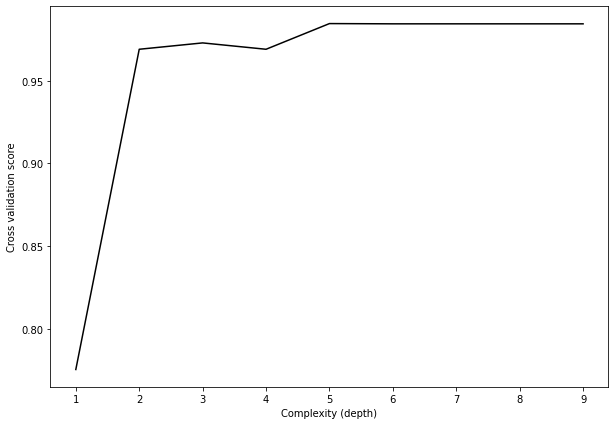

In [ ]:
fig, ax = plt.subplots(1, figsize = (10, 7))

train_scores = []
test_scores  = []
depth = []

for d in range(1, 10):
    
    # modeling 
    RFC = RandomForestClassifier(random_state = 16, max_depth = d)
    
    # get cross validation scores for traning, and store in corresponding lists
    train_score = cross_val_score(RFC, X_train, y_train, cv = 10).mean()
    train_scores.append(train_score)
    
    # keep record of depth 
    depth.append(d)
    
# plot depth against training_scores and test_scores
ax.plot(depth, train_scores, color = "black")
ax.set(xlabel = "Complexity (depth)", ylabel = "Cross validation score")
# get max cross validation score for training set
cv_max = max(train_scores)

print(f"The optimum choice of depth is: {depth[train_scores.index(cv_max)]}")
print(f"The best cross validation score is : {cv_max}")

#### Fitting Model

Now we can create and train our real model with complexity we've just gotten.

In [ ]:
RFC = RandomForestClassifier(random_state = 16, max_depth = 5)
RFC.fit(X_train, y_train)
RFC.score(X_test, y_test)

0.9848484848484849

#### Confusion matrix 

To further understand the performance of our model, we can draw a confusion matrix. We will be using ` ConfusionMatrixDisplay` to visualize the matrix.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def confusion_matrix_disp(model, predictions, true_labels, classes):
    '''
    This is a function that produces and visualize the confusion matrix.
    
    Parameters:
    model, trained model
    predictions, labels predicted with model
    true_labels, the true y labels 
    classes, unique labels 
    
    Return:
    A confusion matrix and its visualization
    '''
    # create confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=classes)
    
    # plot the confusion matrix
    fig, ax = plt.subplots()
    ax.grid(False)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
    
    disp.plot(ax = ax, cmap = "Blues", colorbar = False)

    print("Confusion matrix:")
    print(cm)
    


As we can see, the model only makes one mistake by classifying class 0 species into class 1. Recalling from the mapping information we previously got, `{'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}`, so the confusion matrix told us that a `Adelie` penguin is misclassified as a `Chinstrap`.

Confusion matrix:
[[28  1  0]
 [ 0 13  0]
 [ 0  0 24]]


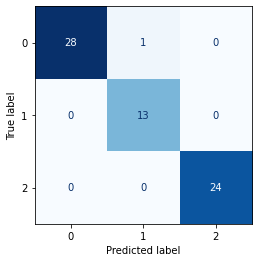

In [ ]:
predictions = RFC.predict(X_test) # predict with our trained model
classes = RFC.classes_

confusion_matrix_disp(RFC, predictions, y_test, classes)

#### Decision Region

The last step of our modeling is to create a plot of decision region, visualizing how our model is working to classify data.

In [ ]:
def plot_regions(model, X, y, Island, quant_cols, ax):
    """
    This function plot the decision boundary for a specific Island
    
    Parameters:
    model, trained model
    X, training data
    y, true labels
    quant_cols, quantitative columns
    ax, the axes to plot on
    """
        
    # this helps to separate data for three islands
    Island_mapping = {'Biscoe': 0, 'Dream': 1, 'Torgersen': 2}
    
    index = X['Island']==Island_mapping[Island]
    X = X[index]
    y = y[index]

    # extract quantitative columns
    quant_col1 = quant_cols[0]
    quant_col2 = quant_cols[1]

    # for convenience, give names to the two columns of the data
    x0 = X[quant_col1]
    x1 = X[quant_col2]
    
    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    # extract model predictions, using the 
    # np.c_ attribute to join together the 
    # two parts of the grid. 
    # array.ravel() converts an multidimensional
    # array into a 1d array, and we use array.reshape()
    # to turn the resulting predictions p 
    # back into 2d
    
    XX = xx.ravel()
    YY = yy.ravel()
    OO = np.ones(XX.shape)*Island_mapping[Island]
    
    XY = pd.DataFrame({
        quant_col1 : XX,
        quant_col2  : YY,
        'Island' : OO
    })

    
    p = model.predict(XY)
    p = p.reshape(xx.shape)
    
    # use contour plot to visualize the predictions

    ax[Island_mapping[Island]].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
    
    # plot the data
    ax[Island_mapping[Island]].scatter(x0, x1, c = y, cmap = "jet", vmin = 0, vmax = 2)
    
    ax[Island_mapping[Island]].set(xlabel = quant_col1, 
                               ylabel = quant_col2,
                               title  = Island) 

    # shut off the x and y ticks
    ax[Island_mapping[Island]].set_xticks([])
    ax[Island_mapping[Island]].set_yticks([])

We've created a helper function to plot decision region for one island. Since we have three Island in total, we will create a new function `Islands_plot` to plot decision regions for three island and add a legend to it using `matplotlib.patches`. 

In [ ]:
import matplotlib.patches as mpatches

def Islands_plot(model, X, y, quant_cols):
  '''
  This function creates the decision region on three islands separately. 

  Parameters:
  model, trained model
  X, training data
  y, true labels
  quant_cols, quantitative columns
  '''
  fig, ax = plt.subplots(1,3, figsize = (16,4))

  # create legend for different species of penguins, and display on the last graph
  red_patch = mpatches.Patch(color='crimson', label='Gentoo')
  blue_patch = mpatches.Patch(color='cornflowerblue', label='Adelie')
  green_patch = mpatches.Patch(color='lime', label='Chinstrap')
  ax[2].legend(loc = 4, handles=[blue_patch, green_patch, red_patch], prop={'size': 9})

  # plot decision region for three islands 
  for i in ['Biscoe','Dream','Torgersen']:
      plot_regions(model, X , y , i, quant_cols, ax)


Decision regions are drown below. According to the design of our function, the colored area will be the prediction made by our trained model. As we can clearly see in the following graphs, there is a blue data point in the green region on the ***Dream*** Island. It shows that there is a `Adelie` penguin being misclassified as `Chinstrap` by our model. It happens may be the result of an unsually long culmen length for that penguin. And order to understand why the decision boundary is drawn in that way, we may look back on the training data to gain more intuition. 


findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


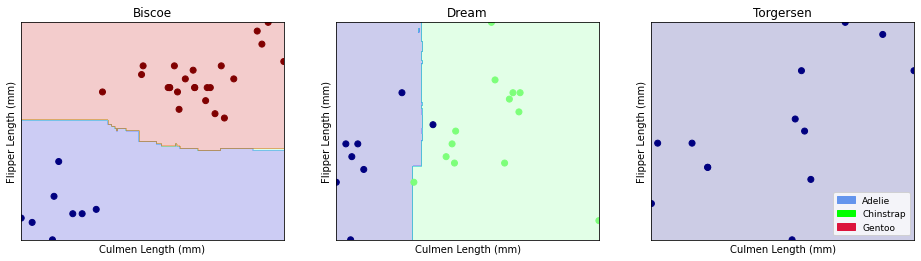

In [ ]:
quant_cols = ['Culmen Length (mm)', 'Flipper Length (mm)']
Islands_plot(RFC, X_test , y_test, quant_cols)

Here we plot the decision regions of training data. As we can see, on the ***Dream*** island, there are overlapping area for `Chinstrap` and `Adelie` penguins near the decision boundary. Our `random forest` model has `max_depth=5`, so it is not an extremely complex model. That is why it draws a relatively straight decision boundary to separate these two species instead of a more curved line. The misclassified penguin has a relatively long culmen length, which makes it closer to the majority of `Chinstrap` penguins, so probably that is why our model made a mistake on that. 

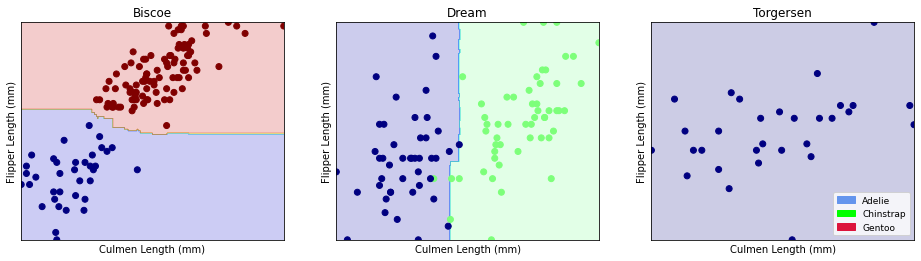

In [ ]:
Islands_plot(RFC, X_train , y_train, quant_cols)

### Model 2: Logistic regression

Import the logistic regression model and set the random state.

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state= 100)

In [ ]:
#Retrieve clean data
X_train = save_X_train
y_train = save_y_train
X_test = save_X_test
y_test = save_y_test

 #### Feature Selection

We have already chosen ***Island*** as our qualitative feature.\
To choose two quantitative features from the remaining six features. Using exhaustive search function we defined before to go through all the possible combinations of features and select two features from six.

In [ ]:
quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)',
        'Flipper Length (mm)', 'Body Mass (g)',
        "Delta 15 N (o/oo)","Delta 13 C (o/oo)"]

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state= 100)

best_cv, best_features = exhaustive_search(LR, df, quant_cols)

print(f"The best feature combination is {best_features}")
print(f"The corresponding highest cross validation score is {best_cv}")

The best feature combination is ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island']
The corresponding highest cross validation score is 0.9727692307692308


#### Complexity Parameter

We have picked the best feature combination which are ***Culmen Length (mm)***, ***Culmen Depth (mm)***, ***Island***, then we use these best features we picked and set our training data to our optimal predictor columns. 

In [ ]:
# setting our training data to our optimal predictor columns
X_train1 = X_train[best_features]
X_test1 = X_test[best_features]

`C`is a regulation parameter that controls the complexity of the logistic regression model.\
We write a function that will run cross validation scores on all given `C`s of the logistic regression model to obtain the optimal `C`:

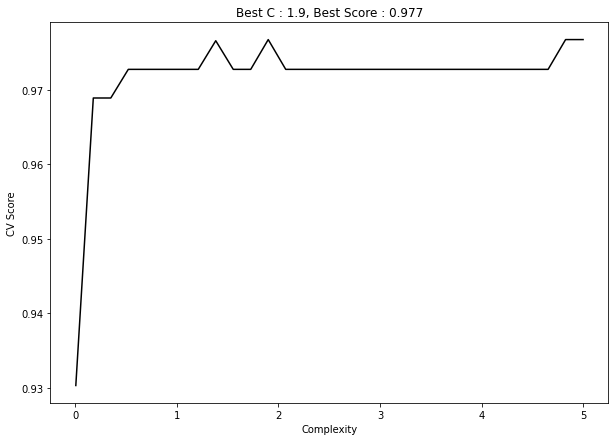

In [ ]:
fig,ax = plt.subplots(1, figsize = (10, 7))

c_values = np.arange(1,21) # create an array of complexity values 

best_score = -np.inf
best_c = 0
cv_scores = []

# implementing the k-fold cross validation
for i in np.linspace(0.005,5,30):
    LR = LogisticRegression(random_state = 10, C=i)
    cv_score = cross_val_score(LR, X_train1, y_train, cv = 10).mean()
    
    if cv_score > best_score:
        best_c = i
        best_score = cv_score
    cv_scores.append(cv_score)
ax.plot(np.linspace(0.005,5,30), cv_scores, color = "black")

l = ax.set(title = "Best C : " + str(round(best_c,2)) + ", Best Score : " + str(round(best_score,3)),
       xlabel = "Complexity", 
       ylabel = "CV Score")

#### Fitting the model

Now we can fit the model using the optimal C and score this model against the test set .

In [ ]:
LR = LogisticRegression(C = best_c, random_state = 10)

LR.fit(X_train1, y_train)

print("The prediction accuracy is: " + str(round(LR.score(X_test1, y_test), 3)))

The prediction accuracy is: 1.0


#### Confusion Matrix

The confusion matrix helps us to better understand the performance of the model, use the confusion matrix funtion we previously written.

Confusion matrix:
[[29  0  0]
 [ 0 13  0]
 [ 0  0 24]]


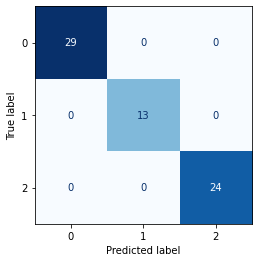

In [ ]:
predictions = LR.predict(X_test1) # predict with our trained model
classes = RFC.classes_

confusion_matrix_disp(LR, predictions, y_test, classes)

Recall the mappings {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}, we can conclude from the confusion matrix that the model can classified the penguins correctly. 

#### Decision Region

Using previously written function to visulize the performance of our model. 

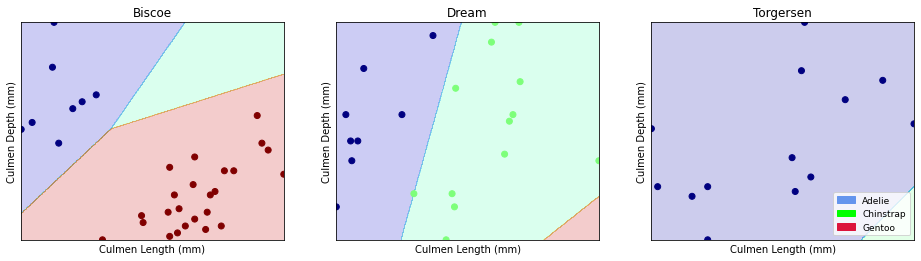

In [ ]:
chosen_quants = ['Culmen Length (mm)', 'Culmen Depth (mm)']
Islands_plot(LR, X_test1 , y_test, chosen_quants)

As we can see in the graphs, all penguins are classified correctly which agrees with our confusion matrix. \
We can still look how well the training performance is by looking at the decision region of the training set.

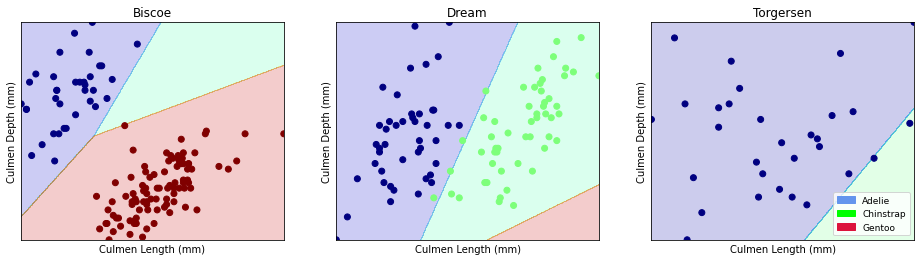

In [ ]:
Islands_plot(LR, X_train1 , y_train, chosen_quants)

As we can see, on dream island, there are some Chinstrap penguins misclassified to Adelie penguins. Since the two quantitive features we chose are Culmen depth and Culmen length. These misclassified penguins may have similar Culmen depth and Culmen length which confuses the model and may led to the misclassification if we use more data to test the model except for the one we used.

### Model 3: Neural Network

In [ ]:
#Retrieve clean data
X_train = save_X_train
y_train = save_y_train
X_test = save_X_test
y_test = save_y_test

#### Feature Selection  

We first deploy neural network `Multi-layer Perceptron Classifier` with a `random_state` of `123` since we have not selected our complexity parameters yet. 

In [ ]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(random_state = 123)

Then we select our features by first looking at what features we have: 

In [ ]:
X_train.columns

Index(['Island', 'Clutch Completion', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)'],
      dtype='object')

We identify the quantitative columns from above, and using a previously written function, `exhaustive_search`, we attain the best feature combination for our specific machine learning model. And according to the first-stage feature selection, `Island` will be the qualitative feature of our choice.

In [ ]:
quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)',
        'Flipper Length (mm)', 'Body Mass (g)',
        "Delta 15 N (o/oo)","Delta 13 C (o/oo)"]
        
best_cv, best_features = exhaustive_search(nn, df, quant_cols)

print(f"The best feature combination is {best_features}")
print(f"The corresponding highest cross validation score is {best_cv}")

The best feature combination is ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island']
The corresponding highest cross validation score is 0.9764615384615384


#### Complexity Parameter  
There are many parameters for `MLPClassifier`, but the one we are most interested in is the `hidden_layer_size`. Hidden layer size accepts a tuple with 1 or more elements. The number of elements represents the number of layers and each element represents the number of nodes in said layer. We can write a function that will give cross validation scores on all combinations of given layers and nodes to obtain the optimal layer size:

In [ ]:
import itertools

def hidden_layer_size(ML, depth, nd):
    '''
    Calculates the optimum hidden layer size given a list of layer depths and nodes.
    Runs combination on all nodes and all depths and records best score 
    Input: MLPClassifier, list of layer depths, list of node values
    Output: Best score, best layer size as tuple
    '''
    ideal_score = 0
    #goes through every layer depth
    for i in depth:
        #obtain all combination of nodes
        hls = [p for p in itertools.product(nd, repeat=i)]
        #goes through every combination
        for j in hls:
            #obtain and record best score and size
            ML = MLPClassifier(hidden_layer_sizes = j, random_state = 123)
            score = cross_val_score(ML, X_train[best_features], y_train, cv=5).mean()
            if score>ideal_score:
                ideal_score = score
                ideal_size = j
    #output and return value
    print("Ideal hidden layer size is "+ str(ideal_size))
    print("with score of: " + str(ideal_score))
    return ideal_score, ideal_size

We decide on going up to 3 layers with nodes `10, 25, 50`, and `100` for selection. The function will start with layer size (10,) and go all the way up to `(100, 100, 100)`.

In [ ]:
layers = [1, 2, 3]
nodes = [10, 25, 50, 100]

best_score, best_size = hidden_layer_size(nn, layers, nodes)

Ideal hidden layer size is (25, 100, 100)
with score of: 0.9845399698340875


The optimum layer size we found is `(25, 100, 100)` with a score of `0.985`. We can see an improvement from the default layer size `(100,)`.  
#### Fitting
Now we can fit the model and see how we do with the test data.

In [ ]:
nn = MLPClassifier(hidden_layer_sizes = best_size, random_state = 123)
nn.fit(X_train[best_features], y_train)
nn.score(X_test[best_features], y_test) 

0.9848484848484849

#### Confusion Matrix  
Using previously written function as to not repeat our code, we plot the confusion matrix:

Confusion matrix:
[[29  0  0]
 [ 0 12  1]
 [ 0  0 24]]


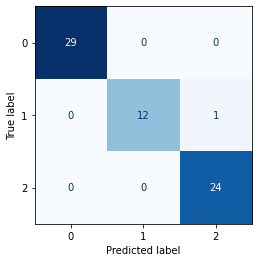

In [ ]:
confusion_matrix_disp(nn, nn.predict(X_test[best_features]), y_test, classes)

`0` corresponds to `Adelie`, `1` corresponds to `Chinstrap`, and `2` corresponds to Gentoo.
The confusion matrix tells us that there is one instance the model predicted a penguin to be Gentoo when the digit was in fact Chinstrap. 

#### Decision Region  
Using previously written function as to not repeat our code, we plot our decision regions.  

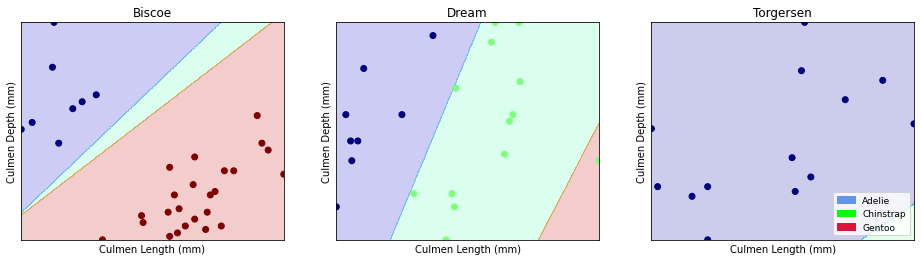

In [ ]:
chosen_quants = ['Culmen Length (mm)', 'Culmen Depth (mm)']
Islands_plot(nn, X_test[best_features] , y_test, chosen_quants)

As we can see in the decision region, one `Chinstrap penguin` is misclassified as a `Gentoo` penguin. This agrees with our confusion matrix.Let us take a look at the decision region on the train data to gain some insight:

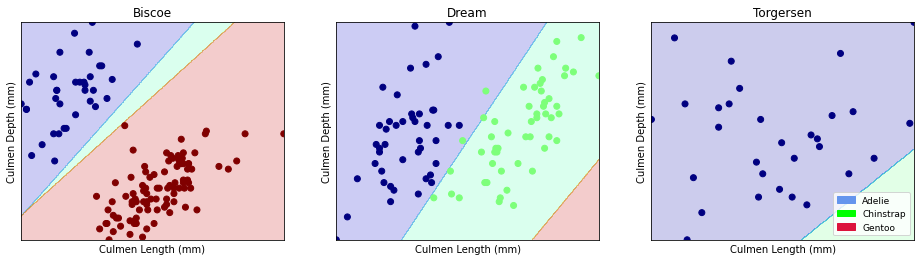

In [ ]:
Islands_plot(nn, X_train[best_features] , y_train, chosen_quants)

As we can see, on dream island, there are a handful of `Chinstrap` penguins with relatively long Culmen depth but short Culmen length. This confuses the model as it is hard to differentiate between `Adelie` and `Chinstrap` when they have similar Culmen length and depth. Also, the model assumed that there are `Gentoo` penguins on Dream island and `Chinstrap` penguins on Biscoe island. This classification led to one `Chinstrap` with especially long Culmen length being mistaken for a `Gentoo` penguin. 

## Discussion/Conclusion  

The `Random Forest` model obtained a score of `0.985`; the `Logistic Regression` model obtained a score of `1.0`; the `Neural Network` model obtained a score of `0.985`. The `Random Forest` model used features: `Island, Culmen Length (mm), and Flipper Length (mm)`. The `Logistic Regression` model used features: `Island, Culmen Length (mm), Culmen Depth (mm)`. The `Neural Network` model used features: `Island, Culmen Length (mm), Culmen Depth (mm)`. 

Since the `Logistic Regression` achieved the highest score, it is the best model for this data set and test data. Additionally, if we look at the running time of `feature selection` and `complexity parameter`, we will realize that `Logistic Regression` is by far the fastest, followed by `Random Forest`, and `Neural Network` coming in last. Therefore, for this data set, we recommend `Linear Regression` as our machine learning model using the features `Island, Culmen Length (mm), Culmen Depth (mm)`.

It is important to note that the performance of these models is based on the limited data we were given to train and the testing data randomly allocated. It is likely that the model's real world performance will not be this good and we will be able to better tell which model is better for this task. For example, the `Logistic Regression` model achieved a perfect score on the test data, but did not achieve a perfect score on the training data. If more or different data were available, we will be able to allocate more data to training and testing and obtain more accurate results. We can also improve performance by including more or less features as we are instructed to only use 1 quantitative and 2 qualitatative features. The truly best set of feature is yet to be found. Afterall, the machine learning model is only as good as the data it is fed. 